# This script is used to explore flow events.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mannwhitneyu
# Import local functions
from functions import plot_storm_cq

In [2]:
# Define dir and site
site = '212058'
fig_dir = f'../output/figs/{site}/'
date_postfire = pd.to_datetime('2020-01-01')
date_postyear = pd.to_datetime('2021-06-30')
date_preyear = pd.to_datetime('2016-07-01')
freq = 'Hourly'
font_size = 14
Q_thre = 1

## 1 Data processing and formating

In [3]:
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'all', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True, format = "%H:%M:%S %d/%m/%Y" )
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(output_fn, index_label='id')

## 2. Plots show start of postfire for each catchment.

### 2.1 Plot for 212058

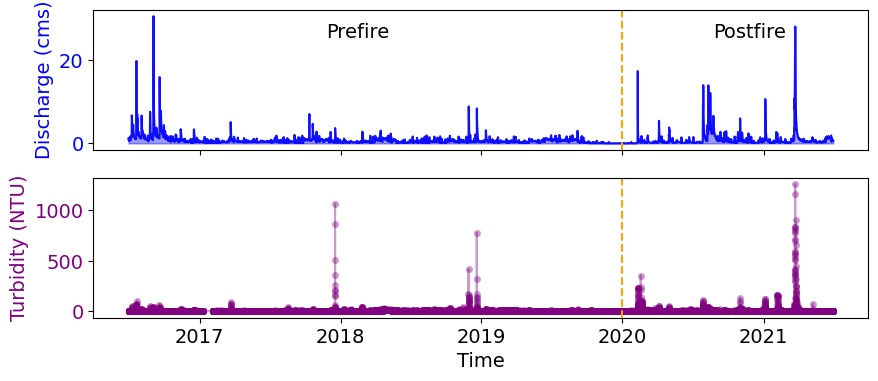

In [4]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="mixed", dayfirst=True)
cq_plot = cq_data[(cq_data['Datetime'] <= date_postyear) & (cq_data['Datetime'] >= date_preyear)]
# cq_plot = cq_data
cols = cq_plot.columns
# Adding a title
# plt.title(f'Flow and Turbidity @{site}', fontsize = font_size)
# Plot discharge using Seaborn
ax = sns.lineplot(x=cols[0], y=cols[-1], data=cq_plot, color='blue', alpha=0.9, ax=axes[0])
# Fill the area below the line
ax.fill_between(cq_plot[cols[0]], cq_plot[cols[-1]], color='blue',  alpha=0.4)
ax.set_ylabel(cols[-1], color='blue', fontsize = font_size)
ax.tick_params(axis='y', labelcolor='blue', labelsize = font_size)
# ax.set_yscale('log')
# ax.set_ylim(0.01, 1e3)

# Plot Turbidity in subplot 2 using Seaborn
sns.lineplot(x=cols[0], y=cols[2], data=cq_plot, ax=axes[1], color='purple', marker='o', \
            markeredgecolor='none', alpha = 0.4, markersize = 5)
axes[1].set_ylabel(cols[2], color='purple', fontsize = font_size)
axes[1].tick_params(axis='y', labelcolor='purple', labelsize = font_size)
axes[1].tick_params(axis='x', labelsize = font_size)
axes[1].set_xlabel('Time', fontsize = font_size)
# ax.set_yscale('log')
# Add a horizontal line at a specific y-value (for example, y = 5)
ax.axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
axes[1].axvline(x=date_postfire, color='orange', linestyle='--', label='Threshold Line')
plt.text(0.3, 0.8, 'Prefire', transform=ax.transAxes, fontsize = font_size)
plt.text(0.8, 0.8, 'Postfire', transform=ax.transAxes, fontsize = font_size)

# Show the plot
plt.savefig(f'../output/figs/{site}/{site}_{freq}_CQ_whole_timeseries_log.png', bbox_inches = 'tight', dpi=300, format = 'png')

## 2.2 Plot event duration and peak flow distribution.

In [5]:
# Read the StormEventSummaryData
storm_summary = pd.read_csv('../output/CQ_analysis/212058/' + \
                            'QAbove_2_212058_StormEventClean.csv', index_col = 'id')

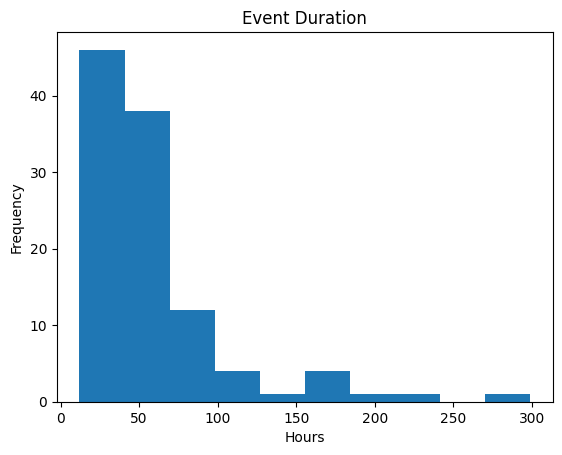

In [6]:
# Hist plot of Event Duration (Hours)
storm_summary.duration_hrs.plot(kind='hist')
plt.xlabel('Hours')
plt.title('Event Duration')
plt.savefig(f'{fig_dir}EventDurationHrs.png', format = 'png', dpi=300)

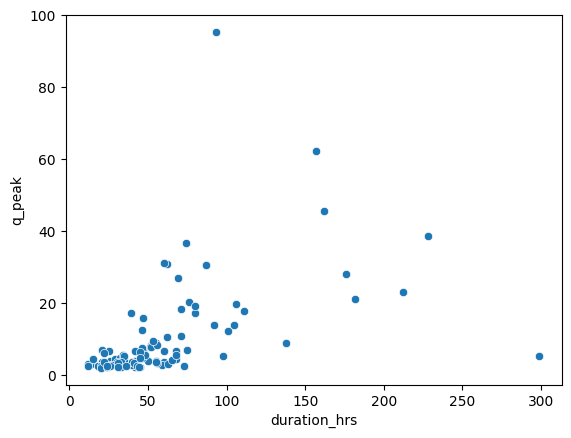

In [63]:
# Scatter plot of Event Duration and Peakflow
sns.scatterplot(data=storm_summary, x = 'duration_hrs', y = 'q_peak')
plt.savefig(f'{fig_dir}EventDurationVsPeakFLow.png', format = 'png', dpi=300)

## 3-1 Explore C-Q for pre and post fire periods

In [6]:
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', index_col = 'id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
storm_data = storm_data[(storm_data['Datetime'] <= date_postyear) & (storm_data['Datetime'] >= date_preyear)]
site = 212058
x_lab = cols[3]
y_lab = cols[2]
storm_data.drop_duplicates('Datetime', inplace=True)

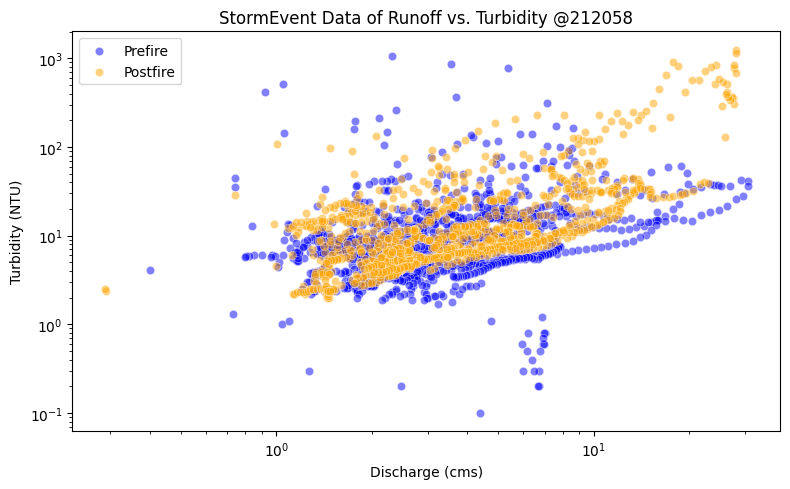

In [7]:
# Scatter plot
plot_storm_cq(storm_data, x_lab, y_lab, freq, site, date_postfire, Q_thre, colors = ['blue', 'orange'], marker='o', \
                  alpha = 0.5, labels = ['Prefire', 'Postfire'])

## 3-2 Plot hysteresis index 

In [4]:
# Select six events of the max peak flow during each periods accroding to QAbove_1_212058_StormEventClean
# import data
hys_fn = 'QAbove_1_212058_StormEventClean.csv'
hys_df = pd.read_csv(f'../output/CQ_analysis/{site}/' + hys_fn, index_col='id')
hys_df['start'] = pd.to_datetime(hys_df['start'], format='mixed', dayfirst=True)
hys_df['end'] = pd.to_datetime(hys_df['end'], format='mixed', dayfirst=True)
pre_hys = hys_df[(hys_df['end'] < date_postfire) & (hys_df['start'] >= date_preyear)].dropna()
post_hys = hys_df[(hys_df['start'] >= date_postfire) & (hys_df['end'] <= date_postyear)].dropna()

# Select six events of the max peak flow during each periods
six_events = [pre_hys['q_peak'].nlargest(6).index, post_hys['q_peak'].nlargest(6).index]
six_eventID = [[pre_hys.loc[ii, :].stormID for ii in six_events[0]], [post_hys.loc[jj, :].stormID for jj in six_events[1]]]
six_eventID[0].sort()
six_eventID[1].sort()
six_eventID[0] = list(map(str, six_eventID[0]))
six_eventID[1] = list(map(str, six_eventID[1]))

In [5]:
# import data
hys_fn = 'HysteresisEventClean.csv'
hys_df = pd.read_csv(f'../output/CQ_analysis/{site}/' + hys_fn, index_col='id')
hys_df['start'] = pd.to_datetime(hys_df['start'], format='mixed', dayfirst=True)
hys_df['end'] = pd.to_datetime(hys_df['end'], format='mixed', dayfirst=True)
hys_df.flsh_index = hys_df.flsh_index.round(2)
hys_df.stormID = hys_df.stormID.astype('str')
pre_hys = hys_df[(hys_df['end'] < date_postfire) & (hys_df['start'] >= date_preyear)].dropna()
post_hys = hys_df[(hys_df['start'] >= date_postfire) & (hys_df['end'] <= date_postyear)].dropna()

### 3-3 Histplot of Flush Index for pre and post fire

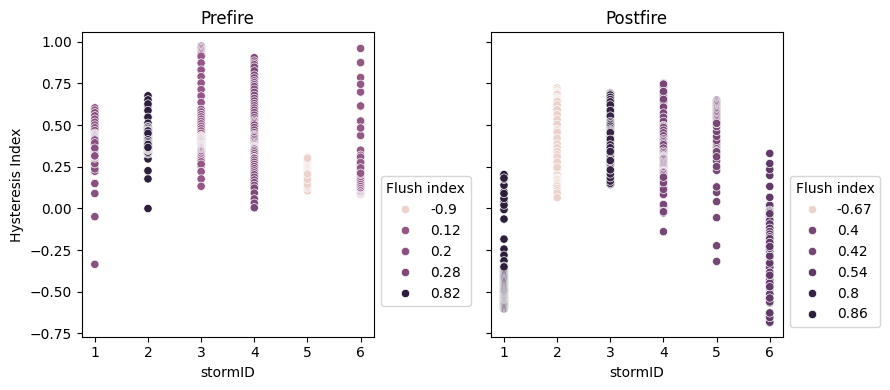

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharex=False, sharey=True)
# 调整子图之间的横向距离，增加间距
plt.subplots_adjust(wspace=0.4) 
data_temp = pd.DataFrame()
for jj in six_eventID[0]:
    data_temp = pd.concat([data_temp, pre_hys[pre_hys.stormID == jj]])
sns.scatterplot(data=data_temp, x='stormID', y='hyst_index', \
                hue='flsh_index', ax=axes[0])
axes[0].set_xticks(six_eventID[0])
axes[0].set_xticklabels(np.arange(1, 7))
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 0.55), title='Flush index')
axes[0].set_ylabel('Hysteresis Index')
axes[0].set_title('Prefire')
# Plot postfire period
data_temp = pd.DataFrame()
for jj in six_eventID[1]:
    data_temp = pd.concat([data_temp, post_hys[post_hys.stormID == jj]])
sns.scatterplot(data=data_temp, x='stormID', y='hyst_index', \
                hue='flsh_index', ax=axes[1])
axes[1].set_xticks(six_eventID[1])
axes[1].set_xticklabels(np.arange(1, 7))
axes[1].set_title('Postfire')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 0.55), title='Flush index')
plt.tight_layout()
plt.savefig(f'{fig_dir}HystFlshIndexScatter.png', format = 'png', dpi=300)

### Plot hysteresis for 6 events before and after bushfire

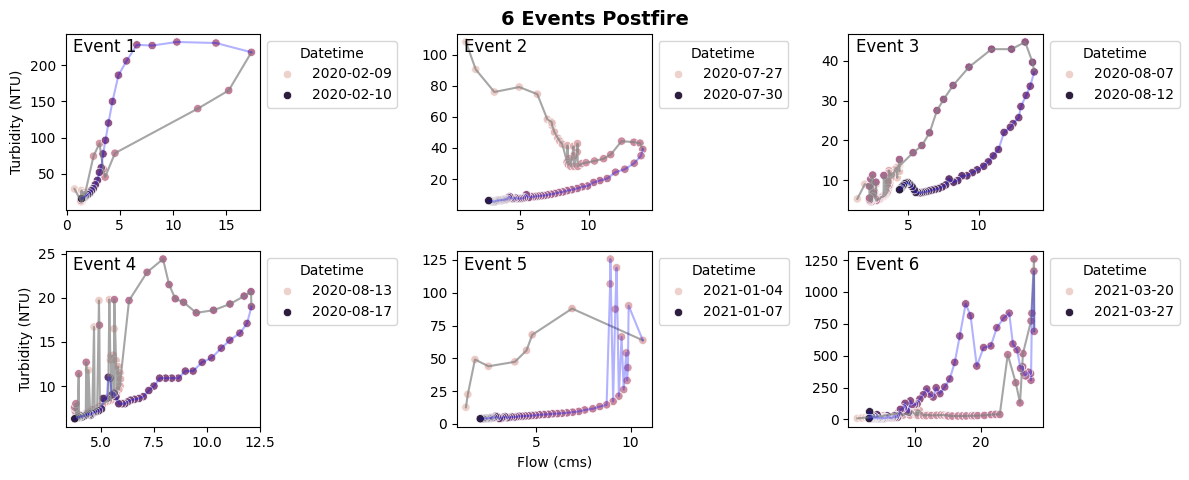

In [98]:
# Select 9 events before and after fire
# Read storm event data
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + \
                        f'Q_above_{Q_thre}_212058_StormEventRefilterData.csv', \
                        index_col = 'id')
# Set stormID to str format
# Select six events of the max peak flow during each periods
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(12, 5))
title = ['6 Events Prefire', '6 Events Postfire'][1]
dt_plot = six_eventID[1] # six_eventID[1] for postfire events and six_eventID[0] for prefire events
kk = 0
# Plot the normalized flow and turbidity if norm_plot = True;
# Otherwise, plot the absolute values of flow and turbidity
norm_plot = False
if norm_plot:
    xx = 'norm_tot_q'; yy = 'norm_c'
    xlab = 'Normalized flow'; ylab = 'Normalized Turbidity'
else:
    xx = 'total_flow'; yy = 'Turbidity (NTU)'
    xlab = 'Flow (cms)'; ylab = yy
for ii in range(2):
    for jj in range(3):
        # Simplified condition for legend
        # lgnd = kk == 5
        lgnd = True
        hys_temp = storm_data[storm_data['stormID'] == float(dt_plot[kk])]
        peak_idx = hys_temp['norm_tot_q'].idxmax()
        # Plot the hysteresis for each period
        sns.scatterplot(hys_temp, x = xx, y =yy, hue='norm_ts', \
                        ax = axes[ii, jj], legend=lgnd)
        sns.lineplot(hys_temp.loc[:peak_idx, :], x = xx, y =yy, \
                        ax = axes[ii, jj], legend=lgnd, color='grey', alpha=0.7)
        sns.lineplot(hys_temp.loc[peak_idx:, :], x = xx, y =yy, \
                        ax = axes[ii, jj], legend=lgnd, color='blue', alpha=0.3)
        # Set event ID as title
        axes[ii, jj].set_title(f'Event {kk + 1}', loc='center', pad=12, x=0.2, y=0.8)
        # Creating a custom legend with absolute time for each subplot
        handles, labels = axes[ii, jj].get_legend_handles_labels()
        # Create custom legend labels: only include the first and last absolute time
        custom_labels = [str(hys_temp.Datetime.values[0][0:10]), str(hys_temp.Datetime.values[-1][0:10])]
        # Set the new legend with the custom labels
        axes[ii, jj].legend([handles[0], handles[-1]], custom_labels, title="Datetime", 
                            loc='upper left', bbox_to_anchor=(1., 1))
        kk += 1
        #Set subplot's xlabel to none
        axes[ii, jj].set_xlabel('')
    # Set labels
    axes[ii, 0].set_ylabel(ylab)
    axes[ii, 1].set_ylabel('')
    axes[ii, 2].set_ylabel('')
        

axes[1, 1].set_xlabel(xlab)
plt.suptitle(title, fontsize=font_size, fontweight='bold', y=0.95)
plt.subplots_adjust(wspace=0.02, hspace=0.05) 
# axes[1, 2].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.tight_layout()
plt.savefig(f'{fig_dir}{title}HysteresisAbsolute{norm_plot}.png', format='png', dpi=300)

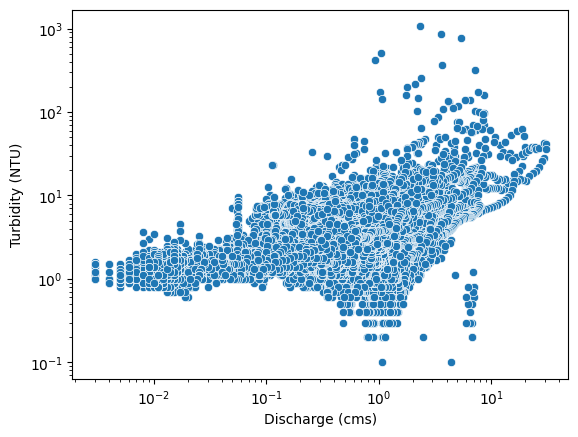

In [30]:
## Explore the relationship in 1/n space
# Read storm event data
freq = 'Hourly'
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'212058_NTU_Discharge_2016_2021.csv', index_col='id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
site = 212058
x_lab = cols[3]
y_lab = cols[2]
storm_data.drop_duplicates('Datetime', inplace=True)
# Scatter plot
sns.scatterplot(x=x_lab, y=y_lab, data=storm_data[storm_data.Datetime < date_postfire])
plt.xscale('log')
plt.yscale('log')

## Plot simulated Turbidity by CQ models

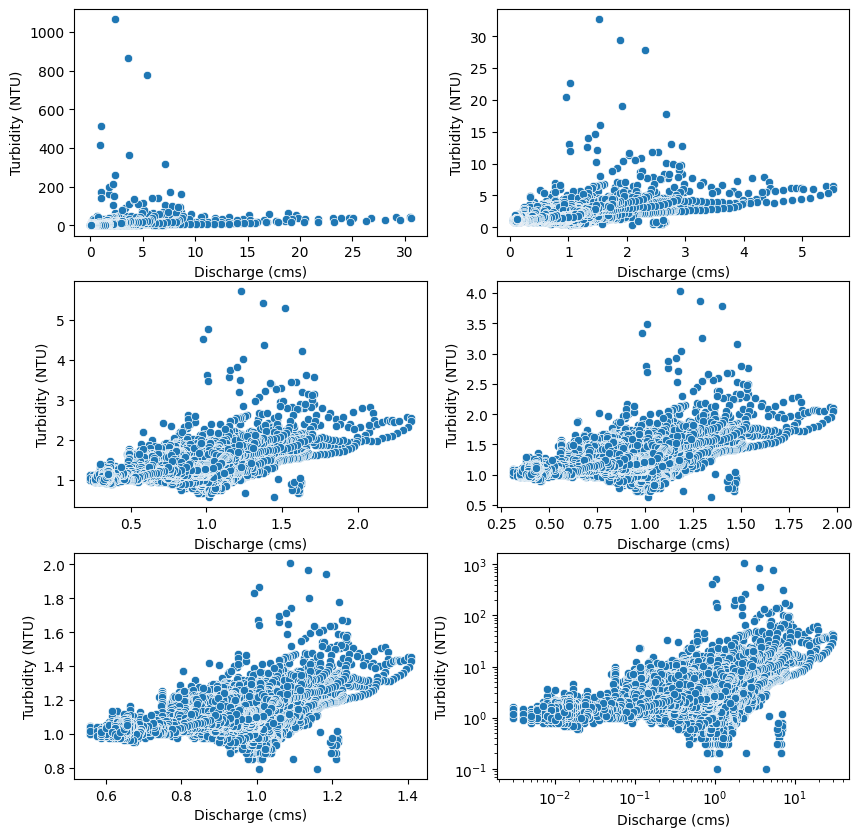

In [42]:
## Explore the relationship in 1/n space
# Read storm event data
freq = 'Hourly'
storm_data = pd.read_csv('../output/CQ_analysis/212058/' + f'212058_NTU_Discharge_2016_2021.csv', index_col='id')
cols = storm_data.columns
storm_data['Datetime'] = pd.to_datetime(storm_data['Datetime'])
x_lab = cols[3]
y_lab = cols[2]
data_copy = storm_data.copy()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 10))
kk = 0
test_n = [1, 2, 4, 5, 10]
for ii in range(3):
    for jj in range(2):
        if kk <= 4:
            n = test_n[kk]
            data_copy.loc[:, x_lab] = np.power(storm_data.loc[:, x_lab], 1/n)
            data_copy.loc[:, y_lab] = np.power(storm_data.loc[:, y_lab], 1/n)
            data_copy.drop_duplicates('Datetime', inplace=True)
            # Scatter plot
            kk += 1
            sns.scatterplot(x=x_lab, y=y_lab, data=data_copy[data_copy.Datetime < date_postfire], ax=axes[ii, jj])
        else:
            sns.scatterplot(x=x_lab, y=y_lab, data=storm_data[storm_data.Datetime < date_postfire], ax=axes[ii, jj])
            ax=axes[ii, jj].set_xscale('log')
            ax=axes[ii, jj].set_yscale('log')
# plt.savefig(f'{fig_dir}test_n.png', format = 'png', dpi=300)

### Create boxplot of residuals from different models

In [43]:
# Calculate residuals by different CQ models
storm_data.dropna(inplace=True)
storm_data['Residual_power'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_power_precal']
storm_data['Residual_mix_precal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Precal']
storm_data['Residual_mix_postcal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Postcal']
storm_data['Residual_mix_fullcal'] = storm_data['Turbidity (NTU)'] - storm_data['Est_Tbdt_mix_Fullcal']
condtn = [storm_data[storm_data['Datetime'] < date_postfire], storm_data[storm_data['Datetime'] >= date_postfire]]
storm_data.loc[condtn[0].index, 'Time Period'] = 'Prefire'
storm_data.loc[condtn[1].index, 'Time Period'] = 'Postfire'
# Boxplot showing residuals
resdl = storm_data.filter(storm_data.columns[-9:])
resdl_long = resdl.melt(id_vars=['Time Period', 'Est_Tbdt_power_precal', 'Est_Tbdt_mix_Precal', 'Est_Tbdt_mix_Postcal', 'Est_Tbdt_mix_Fullcal'], \
           var_name='CQmodel Type', value_name='Residual')
# Apply log transformation to positive values only
resdl_long['Residual_log'] = np.where(resdl_long['Residual'] > 0, np.log(resdl_long['Residual']), resdl_long['Residual'])

c:\Users\u1066632\AppData\Local\anaconda3\envs\bushfire_wq\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Timeseries plot of obs and CQ modelled turbidity

<Axes: xlabel='Datetime', ylabel='Turbidity (NTU)'>

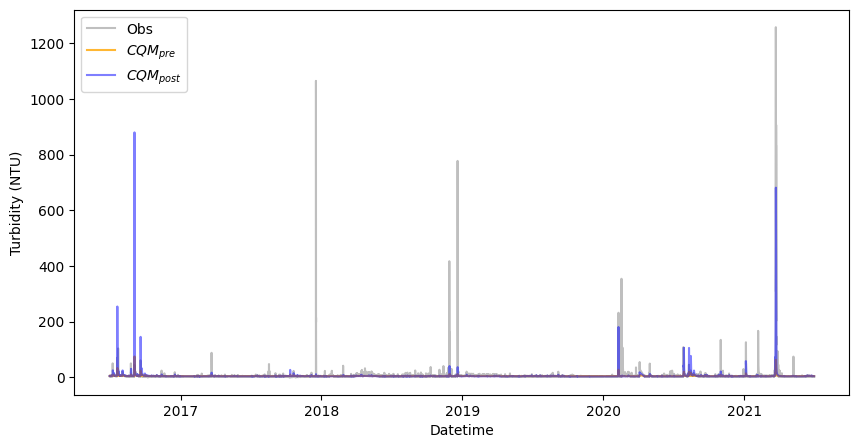

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10, 5), sharex=True, sharey=True)
sns.lineplot(data = storm_data, x = 'Datetime', y = 'Turbidity (NTU)', color = 'grey', \
             alpha = 0.5, label = 'Obs')
sns.lineplot(data = storm_data, x = 'Datetime', y = 'Est_Tbdt_mix_Precal', color = 'orange', \
                alpha = 0.8, label = r'$CQM_{pre}$')
sns.lineplot(data = storm_data, x = 'Datetime', y = 'Est_Tbdt_mix_Postcal', color = 'blue', 
             alpha = 0.5, label = r'$CQM_{post}$')
# sns.scatterplot(data = storm_data, x = 'Datetime', y = 'Est_Tbdt_mix_Fullcal', color = 'purple', size = 1)
# axes[0].legend(loc = 'upper left')
# axes[1].legend(loc = 'upper left')
# axes[0].set_yscale('log')
# plt.yscale('log')
# plt.savefig(f'{fig_dir}CQ_NSE/Obs_Mod_timeseries.png', format = 'png', dpi=300)

In [49]:
# Perform Mann-Whitney U test
if not os.path.exists(f'{fig_dir}MannWhTest.csv'):
    sign_test = {}
    res_type = ['Residual_mix_precal', 'Residual_mix_postcal', 'Residual_mix_fullcal']
    for res in res_type:
        # mannwhitneyu test
        u_stat, p_value = mannwhitneyu(storm_data[storm_data['Time Period'] == 'Prefire'][res], \
                                    storm_data[storm_data['Time Period'] == 'Postfire'][res])
        sign_test[res] = [u_stat, p_value]
    # Convert sign_test to dataframe.
    sign_test_df = pd.DataFrame.from_dict(sign_test)
    sign_test_df.index = ['u_stat', 'p_value']
    sign_test_df.to_csv(f'{fig_dir}MannWhTest.csv')

In [50]:
sign_test_df

,Residual_mix_precal,Residual_mix_postcal,Residual_mix_fullcal
u_stat,2.113343e+08,2.191939e+08,2.184200e+08
p_value,5.084759e-196,7.960892e-299,9.745521e-288


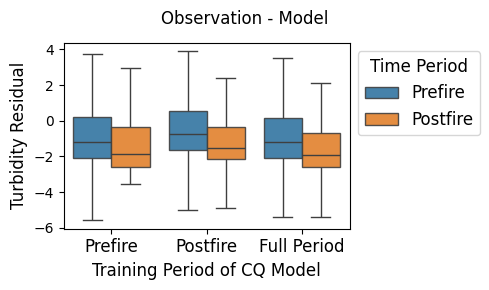

In [51]:
# Create boxplot
fig = plt.figure( figsize=(5, 3))
ax = sns.boxplot(data = resdl_long[resdl_long['CQmodel Type'] != 'Residual_power'], x = 'CQmodel Type', \
            y='Residual', hue = 'Time Period', legend=True, boxprops=dict(alpha=0.9), showfliers=False)
plt.xlabel('Training Period of CQ Model', fontsize = 12)
# plt.xticks(['Residual_mix_precal'])
plt.xticks(ticks=['Residual_mix_precal', 'Residual_mix_postcal', 'Residual_mix_fullcal'], \
           labels=['Prefire', 'Postfire', 'Full Period'], fontsize=12)
plt.ylabel('Turbidity Residual', fontsize = 12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Time Period', fontsize = 12, title_fontsize=12)
# Adjust the horizontal space between the subplots
plt.suptitle('Observation - Model', y=0.95, fontsize = 12)
# plt.text(0.05, 0.90, 'p < 0.05', fontdict={'color':'red'}, transform=ax.transAxes)
# plt.text(0.75, 0.90, 'p < 0.05', fontdict={'color':'red'}, transform=ax.transAxes)
plt.tight_layout()
# plt.savefig(f'{fig_dir}Residual_no_outlier_mix_precal_model.png', format = 'png', dpi=300)

### Scatter plot of calculated Turbidity

In [52]:
import matplotlib.cm as cm
lab_fs = 10
tick_fs = 10

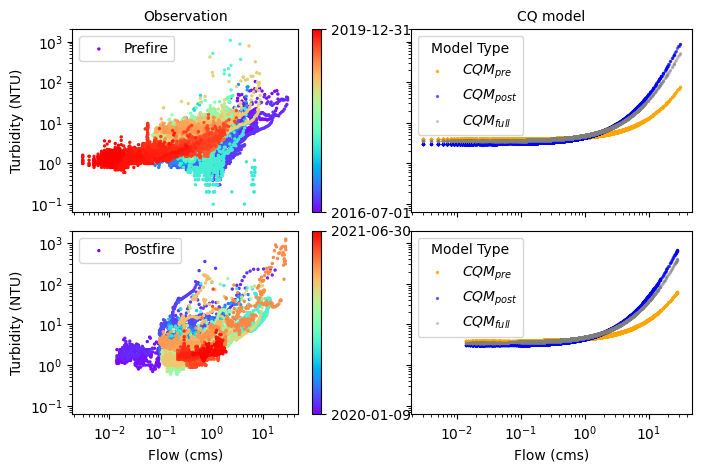

In [53]:
# Plot 2: Scatter plot of turbidity
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(8, 5))
# Using gradient colors for data one year before fire
predata = storm_data[storm_data['Time Period'] == 'Prefire']
date_nums = predata.Datetime.astype(np.int64) // 1e9
norm = plt.Normalize(date_nums.min(), date_nums.max())
colors = cm.rainbow(norm(date_nums)) 
sm = cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
sm.set_array([])  # Required for the ScalarMappable object

# Plot the observed data.
scatter_pre = axes[0, 0].scatter(predata.loc[:, 'Discharge (cms)'], predata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = colors, label = 'Prefire')
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'orange', alpha = 0.8) 
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'blue', alpha = 0.5)  
axes[0, 1].scatter(predata.loc[:, 'Discharge (cms)'], predata['Est_Tbdt_mix_Fullcal'].values, s = 2,
        label=r'$CQM_{full}$', color = 'grey', alpha = 0.3) 

#Add color bars
axes[0, 0].set_title('Observation', fontsize = lab_fs)
axes[0, 1].set_title('CQ model', fontsize = lab_fs)
axes[0, 1].tick_params(axis='both', which = 'major', labelsize = tick_fs)
# Add the color bar
# cbar = plt.colorbar(scatter_pre)
cbar = fig.colorbar(sm, ax=axes[0, 0])
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.set_ticklabels([(str(predata.Datetime.values[0])[:10]), str(predata.Datetime.values[-1])[:10]])

# Settings for the figure for postfire
postdata = storm_data[storm_data['Time Period'] == 'Postfire']
date_nums = postdata.Datetime.astype(np.int64) // 1e9
norm_post = plt.Normalize(date_nums.min(), date_nums.max())
colors = cm.rainbow(norm_post(date_nums)) 
sm = cm.ScalarMappable(cmap=cm.rainbow, norm=norm_post)
sm.set_array([])  # Required for the ScalarMappable object

# Plot the observed data.
scatter_pre = axes[1, 0].scatter(postdata.loc[:, 'Discharge (cms)'], postdata.loc[:, 'Turbidity (NTU)'], \
                                s = 2, color = colors, label = 'Postfire')
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Precal'].values, s = 2,
        label=r'$CQM_{pre}$', color = 'orange', alpha = 0.8) 
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Postcal'].values, s = 2,
        label=r'$CQM_{post}$', color = 'blue', alpha = 0.5)  
axes[1, 1].scatter(postdata.loc[:, 'Discharge (cms)'], postdata['Est_Tbdt_mix_Fullcal'].values, s = 2,
        label=r'$CQM_{full}$', color = 'grey', alpha = 0.3) 
plt.xscale('log')
plt.yscale('log')
# Set figure legend
for ii in range(2):
    for jj in range(2):
        axes[ii, jj].legend(fontsize = lab_fs)
    axes[ii, 1].legend(title = 'Model Type', fontsize = lab_fs)
    axes[1, ii].set_xlabel('Flow (cms)', fontsize = lab_fs)
#Add color bars
# cbar = plt.colorbar(scatter_pre)
cbar = fig.colorbar(sm, ax=axes[1, 0])
cbar.set_ticks([norm_post.vmin, norm_post.vmax])
cbar.set_ticklabels([(str(postdata.Datetime.values[0])[:10]), str(postdata.Datetime.values[-1])[:10]])
# Set xaxis and y-axis label
axes[0, 0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
axes[1, 0].set_ylabel('Turbidity (NTU)', fontsize = lab_fs)
plt.subplots_adjust(hspace=0.1)
# Save figure
# plt.savefig(f'{fig_dir}calCQFit.png', format='png', dpi=300)